In [9]:
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"
con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [10]:
import pandas as pd
import numpy as np


def get_data():
    df = pd.read_sql_query("SELECT * FROM ACGRWide", con)

    df.replace('*', np.nan, inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    df.fillna(df.mean(), inplace=True)
    df.fillna(0, inplace=True)
    return df

def get_data_xgb():
    # This function is used for XGBoost training without removing missing values
    df = pd.read_sql_query("SELECT * FROM ACGRWide", con)

    df.replace('*', np.nan, inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    return df

df = get_data()


### Data Summary

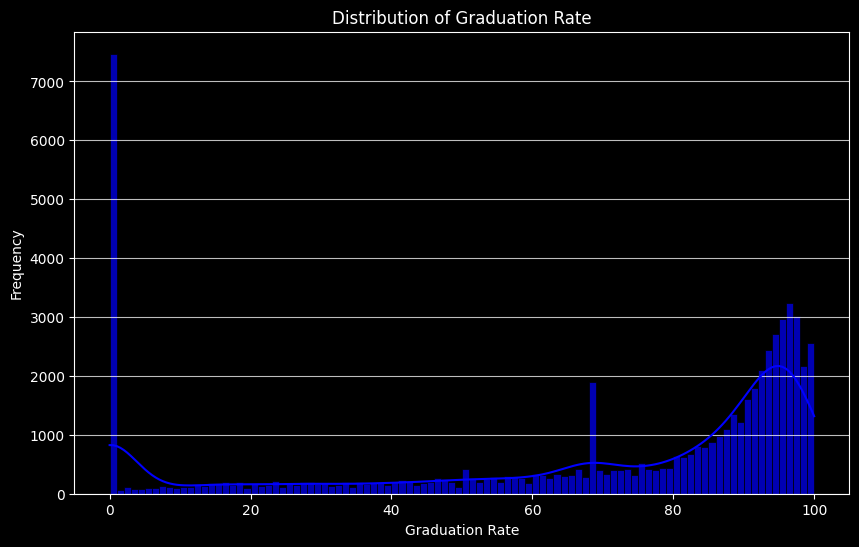

Mean Graduation Rate: 68.04490446940648


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['RegHSDiplomaRate.TA'].dropna(), bins=100, kde=True, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Graduation Rate")
plt.ylabel("Frequency")
plt.title("Distribution of Graduation Rate")
plt.grid(axis='y', alpha=0.75)
plt.show()


mean_graduation_rate = df['RegHSDiplomaRate.TA'].mean()
print(f"Mean Graduation Rate: {mean_graduation_rate}")  

# Lasso Models

## Graduation Rate as Target Variable

c:\School\STATS 170A\DS-Capstone-Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36840.25185671821, tolerance: 5773.453353340742
  model = cd_fast.enet_coordinate_descent_gram(
c:\School\STATS 170A\DS-Capstone-Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32973.4351972267, tolerance: 5695.014843531422
  model = cd_fast.enet_coordinate_descent_gram(
c:\School\STATS 170A\DS-Capstone-Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30484.61334523931, tolerance: 5656.914594486903
  model = cd_fast.enet_coordinate_descent_gram(
c:\School\STATS 170A\DS-Capst


GEDRate.SS: 99.43322787787794
CohortStudents.GF: -25.071729595101058
Biliteracy.RH: -18.055604414450112
CPPRate.TA: 15.432499398921301
UniReqs.GF: -13.67757462882472
CohortStudents.RA: -11.787250776355055
UniReqs.GM: -11.204783832977503
GEDRate.SE: 10.782992048432487
CohortStudents.GM: -9.054486270434413
GEDRate.RW: -7.5429815743657915
GEDRate.RP: -6.609023552949929
CohortStudents.RW: -6.3067514077223334
Other.GM: -5.703419001004626
MeritRate.SS: -5.33723477303142
GEDRate.RT: -5.275014398088969
StillEnrolledRate.SS: 5.013751893653193
CPP.RT: 4.760740966059153
UniReqs.RA: 4.705838923987437
CohortStudents.RB: -4.66443448310463
UniReqsPercent.GF: 4.604256849164258
GEDRate.SD: -4.524571154046096
CPP.RW: -3.7347939428454935
CPP.SS: -3.5934959988938147
UniReqsPercent.SS: -3.5346755765483606
CPP.SD: 3.4270203015932568
Dropout.GM: -3.1683427543035108
UniReqs.SE: -2.994384983206025
BiliteracyRate.RF: -2.8986259466193935
DistrictCode: 2.6469710738160788
UniReqs.RT: -2.638194124568433
CohortStud

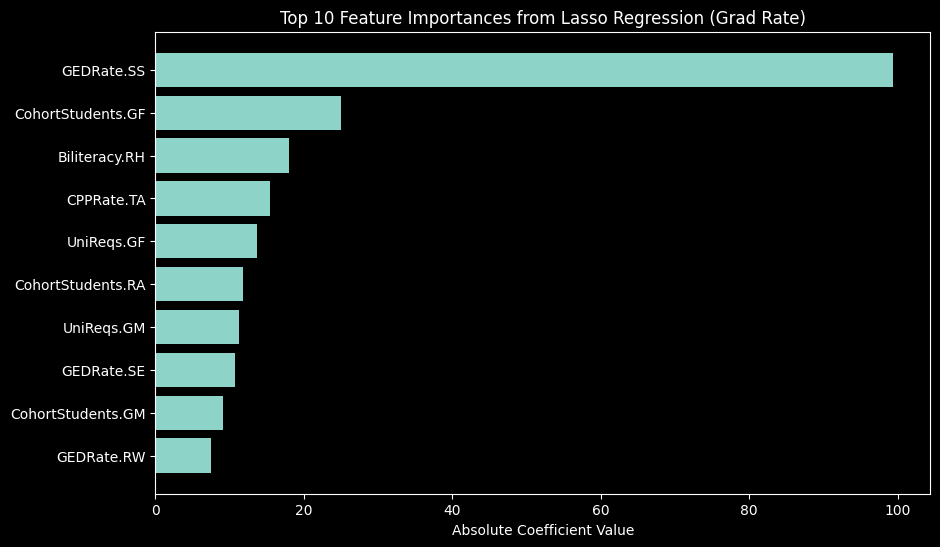

In [31]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline

target_column = "RegHSDiplomaRate.TA"

X = df.drop(columns=[target_column])
y = df[target_column]

# Remove all features that begin with RegHSDiploma but are not the target column
X = X.loc[:, ~X.columns.str.startswith('RegHSDiploma')]

# Drop rows where y is NaN
mask = y.notna()
X = X[mask]
y = y[mask]

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42, max_iter=10000)) 
])

# Fit the model
pipe.fit(X_reduced, y)

# Get the coefficients of the Lasso model
lasso_coefficients = pipe['lasso'].coef_

coef_feature_pairs = list(zip(X.columns, lasso_coefficients))
sorted_pairs = sorted(coef_feature_pairs, key=lambda x: abs(x[1]), reverse=True)
print()
for feature, coef in sorted_pairs:
    print(f"{feature}: {coef}")

# Plot top 10 feature importances
top_n = 10
top_features = sorted_pairs[:top_n]

plt.figure(figsize=(10, 6))
plt.barh([f[0] for f in top_features], [abs(f[1]) for f in top_features])
plt.xlabel("Absolute Coefficient Value")
plt.title("Top 10 Feature Importances from Lasso Regression (Grad Rate)")
plt.gca().invert_yaxis()
plt.show()

### Graduation Rate Model Validation (DID NOT CONVERGE)

In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe.fit(X_train, y_train)

# Make predictions
y_pred = pipe.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_2 = pipe.score(X_test, y_test)

print(f"R^2 Score: {r_2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Best alpha value: {pipe['lasso'].alpha_}")

c:\School\STATS 170A\DS-Capstone-Project\.venv\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['AdultEd.GZ' 'AdultEdRate.GZ' 'Biliteracy.GZ' 'BiliteracyRate.GZ'
 'CPP.GZ' 'CPPRate.GZ' 'CohortStudents.GZ' 'Dropout.GZ' 'DropoutRate.GZ'
 'Exemption.GZ' 'ExemptionRate.GZ' 'GED.GZ' 'GEDRate.GZ' 'Merit.GZ'
 'MeritRate.GZ' 'Other.GZ' 'OtherRate.GZ' 'SPED.GZ' 'SPEDRate.GZ'
 'UniReqs.GZ' 'UniReqsPercent.GZ']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\School\STATS 170A\DS-Capstone-Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17744.627673450857, tolerance: 4528.307144613252
  model = cd_fast.enet_coordinate_descent_gram(
c:\School\STATS 170A\DS-Capstone-Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: Co

R^2 Score: 0.7275564301306868
Mean Squared Error: 323.00734334624144
Root Mean Squared Error: 17.97240505180766
Best alpha value: 0.0219256160513263


c:\School\STATS 170A\DS-Capstone-Project\.venv\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['AdultEd.GZ' 'AdultEdRate.GZ' 'Biliteracy.GZ' 'BiliteracyRate.GZ'
 'CPP.GZ' 'CPPRate.GZ' 'CohortStudents.GZ' 'Dropout.GZ' 'DropoutRate.GZ'
 'Exemption.GZ' 'ExemptionRate.GZ' 'GED.GZ' 'GEDRate.GZ' 'Merit.GZ'
 'MeritRate.GZ' 'Other.GZ' 'OtherRate.GZ' 'SPED.GZ' 'SPEDRate.GZ'
 'UniReqs.GZ' 'UniReqsPercent.GZ']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\School\STATS 170A\DS-Capstone-Project\.venv\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['AdultEd.GZ' 'AdultEdRate.GZ' 'Biliteracy.GZ' 'BiliteracyRate.GZ'
 'CPP.GZ' 'CPPRate.GZ' 'CohortStudents.GZ' 'Dropout.GZ' 'DropoutRate.GZ'
 'Exemption.GZ' 'ExemptionRate.GZ' 'GED.GZ' 'GEDRate.GZ' 'Merit.GZ'
 'MeritRate.GZ' 'Other.GZ' 'OtherRate.GZ' 'SPED.GZ' 'SPEDRate.GZ'
 'UniReqs.GZ'

### Graduation Rate Residuals

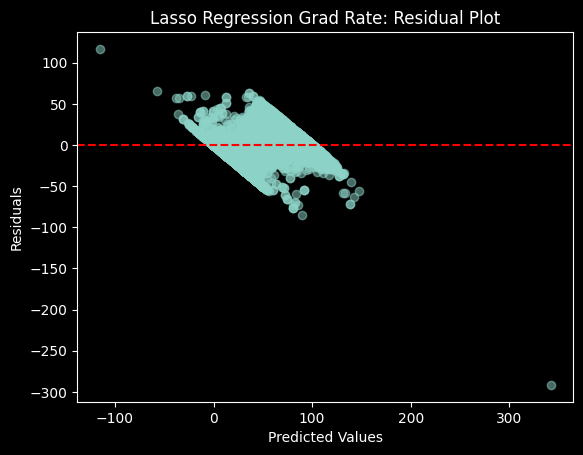

In [33]:
y_test_numeric = pd.to_numeric(y_test, errors='coerce')

# Calculate residuals
residuals = y_test_numeric - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Lasso Regression Grad Rate: Residual Plot")
plt.show()

### Graduation Rate Actual vs. Predicted

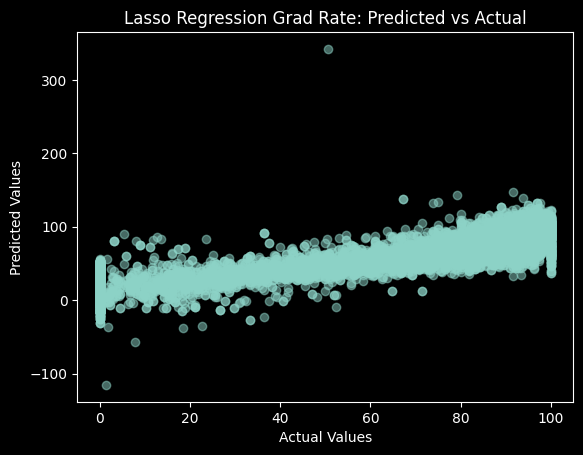

In [34]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso Regression Grad Rate: Predicted vs Actual")
plt.show()

## CSU/UC Readiness as Target Variable



AdultEd.SS: 17.624607433813008
Other.SS: 9.050125254773338
UniReqsPercent.GF: 8.260171223829339
SPED.SS: 7.9208947160298955
UniReqsPercent.GM: 5.3582742839895126
SPED.SE: -5.330171726419297
Other.SE: -3.832501508005262
CPP.SS: 3.45030381255197
MeritRate.GF: -3.2148099765850655
AdultEd.RW: 1.8433802956356793
CPP.SE: -1.6079472487866846
MeritRate.GM: -1.555678711980348
UniReqsPercent.SE: -1.5278969543827197
UniReqsPercent.SS: 1.523348831130791
RegHSDiplomaRate.GF: -1.2777106431340826
RegHSDiplomaRate.GM: -1.2621856438506593
BiliteracyRate.GF: -1.1574931870177938
UniReqs.GF: -0.7802878786870283
Other.RT: -0.7734697418944811
RegHSDiplomaRate.SS: 0.6138241420867873
BiliteracyRate.GM: -0.6045063452958803
SPED.RT: -0.568142147530268
RegHSDiplomaRate.RT: 0.4121931112743902
GED.SS: 0.27440710873876817
GED.SE: -0.22392654803983064
UniReqsPercent.RW: -0.17470563833836006
MeritRate.SE: 0.15531046326517214
Merit.SS: -0.14628275131531052
RegHSDiploma.RH: -0.13976289608279827
Other.RA: 0.13779664338

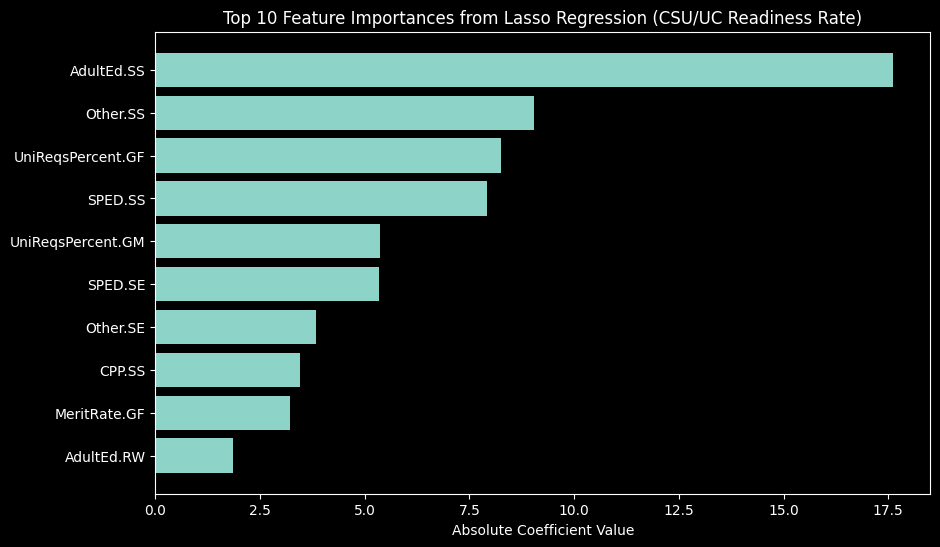

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

target_column = "UniReqsPercent.TA"

# Reset df
df = get_data()

# Remove all features that begin with UniReqs but are not the target column
X = df.drop(columns=[col for col in df.columns if col.startswith('UniReqs') and col != target_column])


X = df.drop(columns=[target_column])
y = df[target_column]


# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42, max_iter=10000)) 
])

# Fit the model
pipe.fit(X_reduced, y)

# Get the coefficients of the Lasso model
lasso_coefficients = pipe['lasso'].coef_


coef_feature_pairs = list(zip(X.columns, lasso_coefficients))
sorted_pairs = sorted(coef_feature_pairs, key=lambda x: abs(x[1]), reverse=True)
print()
for feature, coef in sorted_pairs:
    print(f"{feature}: {coef}")

# Plot top 10 feature importances
top_n = 10
top_features = sorted_pairs[:top_n]

plt.figure(figsize=(10, 6))
plt.barh([f[0] for f in top_features], [abs(f[1]) for f in top_features])
plt.xlabel("Absolute Coefficient Value")
plt.title("Top 10 Feature Importances from Lasso Regression (CSU/UC Readiness Rate)")
plt.gca().invert_yaxis()
plt.show()

### CSU/UC Readiness Model Validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe.fit(X_train, y_train)

# Make predictions
y_pred = pipe.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_2 = pipe.score(X_test, y_test)

print(f"R^2 Score: {r_2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Best alpha value: {pipe['lasso'].alpha_}")

c:\School\STATS 170A\DS-Capstone-Project\.venv\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['AdultEd.GZ' 'AdultEdRate.GZ' 'Biliteracy.GZ' 'BiliteracyRate.GZ'
 'CPP.GZ' 'CPPRate.GZ' 'CohortStudents.GZ' 'Dropout.GZ' 'DropoutRate.GZ'
 'Exemption.GZ' 'ExemptionRate.GZ' 'GED.GZ' 'GEDRate.GZ' 'Merit.GZ'
 'MeritRate.GZ' 'Other.GZ' 'OtherRate.GZ' 'SPED.GZ' 'SPEDRate.GZ'
 'UniReqs.GZ' 'UniReqsPercent.GZ']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\School\STATS 170A\DS-Capstone-Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17744.627673450857, tolerance: 4528.307144613252
  model = cd_fast.enet_coordinate_descent_gram(
c:\School\STATS 170A\DS-Capstone-Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: Co

### CSU/UC Readiness Residuals


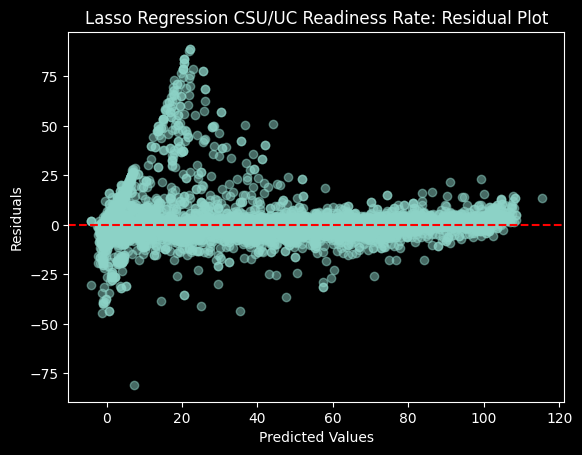

In [18]:
# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Lasso Regression CSU/UC Readiness Rate: Residual Plot")
plt.show()

### CSU/UC Readiness Actual vs. Predicted

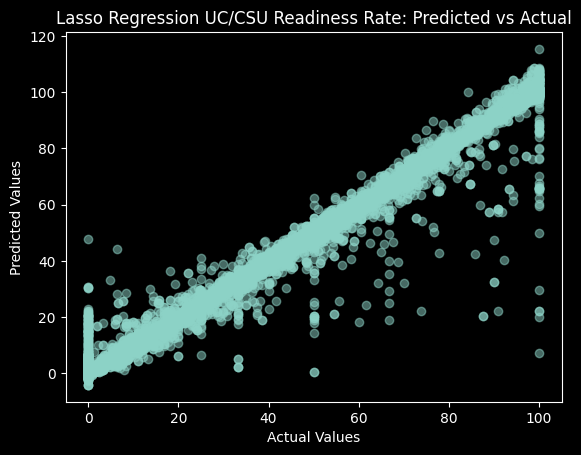

In [19]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso Regression UC/CSU Readiness Rate: Predicted vs Actual")
plt.show()

# XGBoost Models

## CSU/UC Readiness as Target

Feature ranking:
1. UniReqsPercent.SS (0.4107801914215088)
2. UniReqsPercent.GF (0.23874910175800323)
3. UniReqsPercent.GM (0.14847435057163239)
4. UniReqs.TA (0.06576469540596008)
5. UniReqs.SS (0.02412658929824829)
6. RegHSDiploma.SS (0.016896294429898262)
7. UniReqsPercent.RH (0.011407354846596718)
8. UniReqsPercent.RW (0.006535166874527931)
9. RegHSDiploma.TA (0.006253304425626993)
10. RegHSDiploma.GM (0.005923961754888296)
11. RegHSDiploma.GF (0.005453579127788544)
12. CohortStudents.TA (0.004518489353358746)
13. UniReqsPercent.SD (0.0038108909502625465)
14. CohortStudents.SS (0.003666322911158204)
15. RegHSDiplomaRate.TA (0.00318132434040308)
16. CohortStudents.GF (0.0031121550127863884)
17. Merit.GM (0.003036793787032366)
18. RegHSDiplomaRate.GF (0.002222924493253231)
19. DropoutRate.GM (0.0020279220771044493)
20. MeritRate.TA (0.0018911639926955104)
21. CohortStudents.RW (0.0017707496881484985)
22. SPEDRate.SS (0.0016845065401867032)
23. RegHSDiploma.RW (0.0016074157319962978)


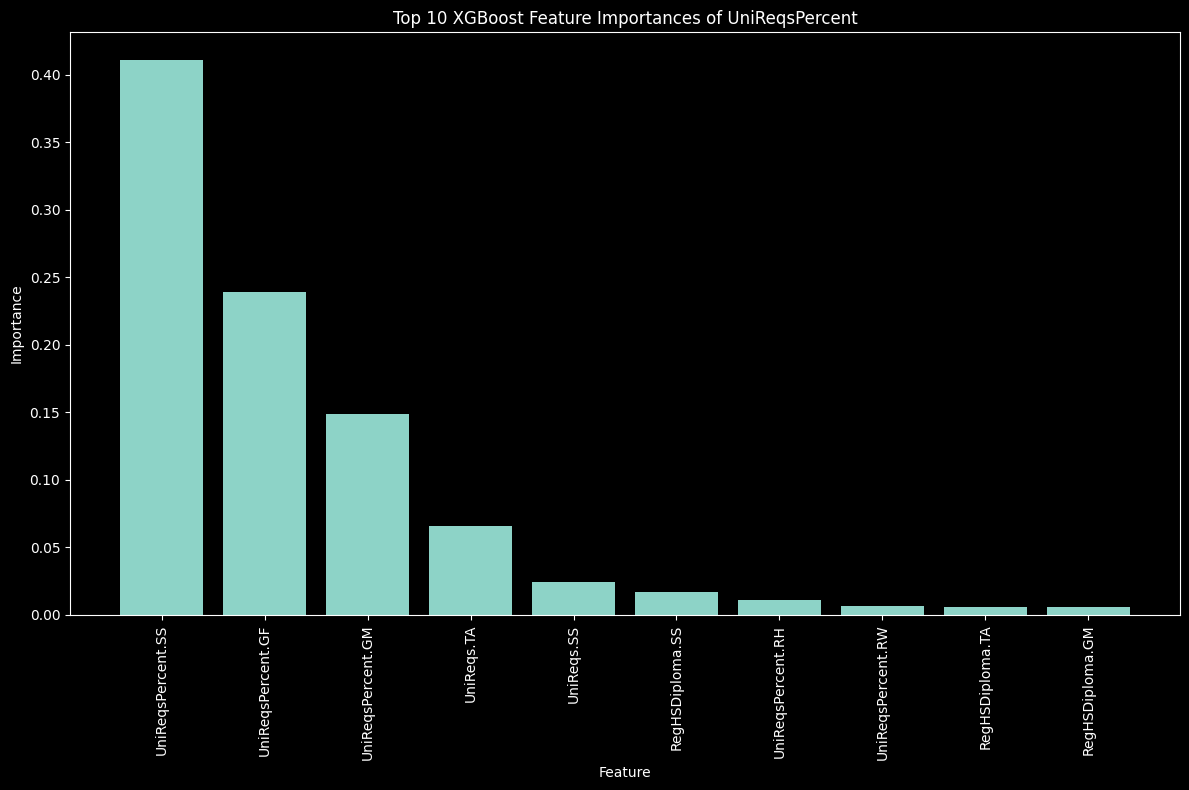

In [20]:
import xgboost as xgb

target_col = 'UniReqsPercent.TA'

# Reset df
df = get_data_xgb()

# Remove rows where y is NaN or infinite or too large
mask = y.notna() & np.isfinite(y) & (np.abs(y) < 1e10)
X = X[mask]
y = y[mask]

# XGBoost for UniReqsPercent as target variable
xgb_regressor_uni = xgb.XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6,  
    subsample=0.8,  
    colsample_bytree=0.8, 
    missing=np.nan, 
    random_state=42
)

# Fit the model
xgb_regressor_uni.fit(X, y)

# Get feature importances
importances_uni = xgb_regressor_uni.feature_importances_
feature_names_uni = X.columns
indices_uni = np.argsort(importances_uni)[::-1]
print("Feature ranking:")
for f in range(len(feature_names_uni)):
    print(f"{f + 1}. {feature_names_uni[indices_uni[f]]} ({importances_uni[indices_uni[f]]})")

# Plot top 10 feature importances for UniReqsPercent
top_n = 10
top_indices = indices_uni[:top_n]
plt.figure(figsize=(12, 8))
plt.bar(range(top_n), importances_uni[top_indices], align='center')
plt.xticks(range(top_n), feature_names_uni[top_indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Top 10 XGBoost Feature Importances of UniReqsPercent")
plt.tight_layout()
plt.show()

### Model Validation

In [21]:
# Split the data into training and testing sets
from sklearn.metrics import mean_absolute_error, r2_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
xgb_regressor_uni.fit(X_train, y_train)

# Make predictions
y_pred = xgb_regressor_uni.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.6062214842077986
Root Mean Squared Error: 0.7786022631663735
Mean Absolute Error: 0.3633171947243512
R^2 Score: 0.9993864067216641


### Residuals

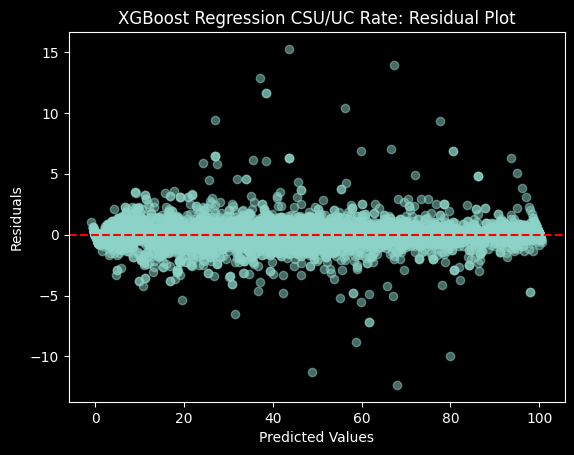

In [22]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("XGBoost Regression CSU/UC Rate: Residual Plot")
plt.show()

### Actual vs. Predicted

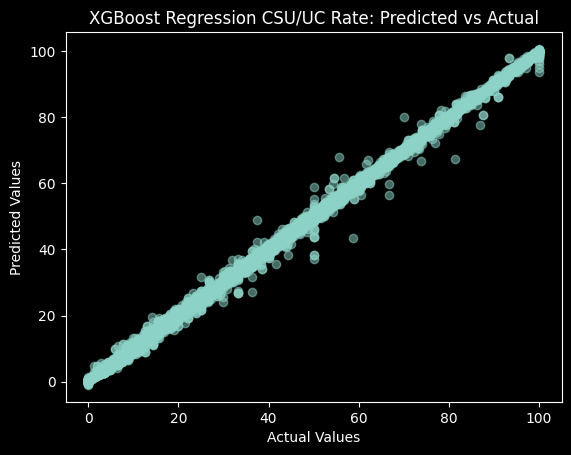

In [23]:
# Plot actual vs. predicted
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost Regression CSU/UC Rate: Predicted vs Actual")
plt.show()

## Graduation Rate as Target

Feature ranking:
1. UniReqsPercent.SS (0.4107801914215088)
2. UniReqsPercent.GF (0.23874910175800323)
3. UniReqsPercent.GM (0.14847435057163239)
4. UniReqs.TA (0.06576469540596008)
5. UniReqs.SS (0.02412658929824829)
6. RegHSDiploma.SS (0.016896294429898262)
7. UniReqsPercent.RH (0.011407354846596718)
8. UniReqsPercent.RW (0.006535166874527931)
9. RegHSDiploma.TA (0.006253304425626993)
10. RegHSDiploma.GM (0.005923961754888296)
11. RegHSDiploma.GF (0.005453579127788544)
12. CohortStudents.TA (0.004518489353358746)
13. UniReqsPercent.SD (0.0038108909502625465)
14. CohortStudents.SS (0.003666322911158204)
15. RegHSDiplomaRate.TA (0.00318132434040308)
16. CohortStudents.GF (0.0031121550127863884)
17. Merit.GM (0.003036793787032366)
18. RegHSDiplomaRate.GF (0.002222924493253231)
19. DropoutRate.GM (0.0020279220771044493)
20. MeritRate.TA (0.0018911639926955104)
21. CohortStudents.RW (0.0017707496881484985)
22. SPEDRate.SS (0.0016845065401867032)
23. RegHSDiploma.RW (0.0016074157319962978)


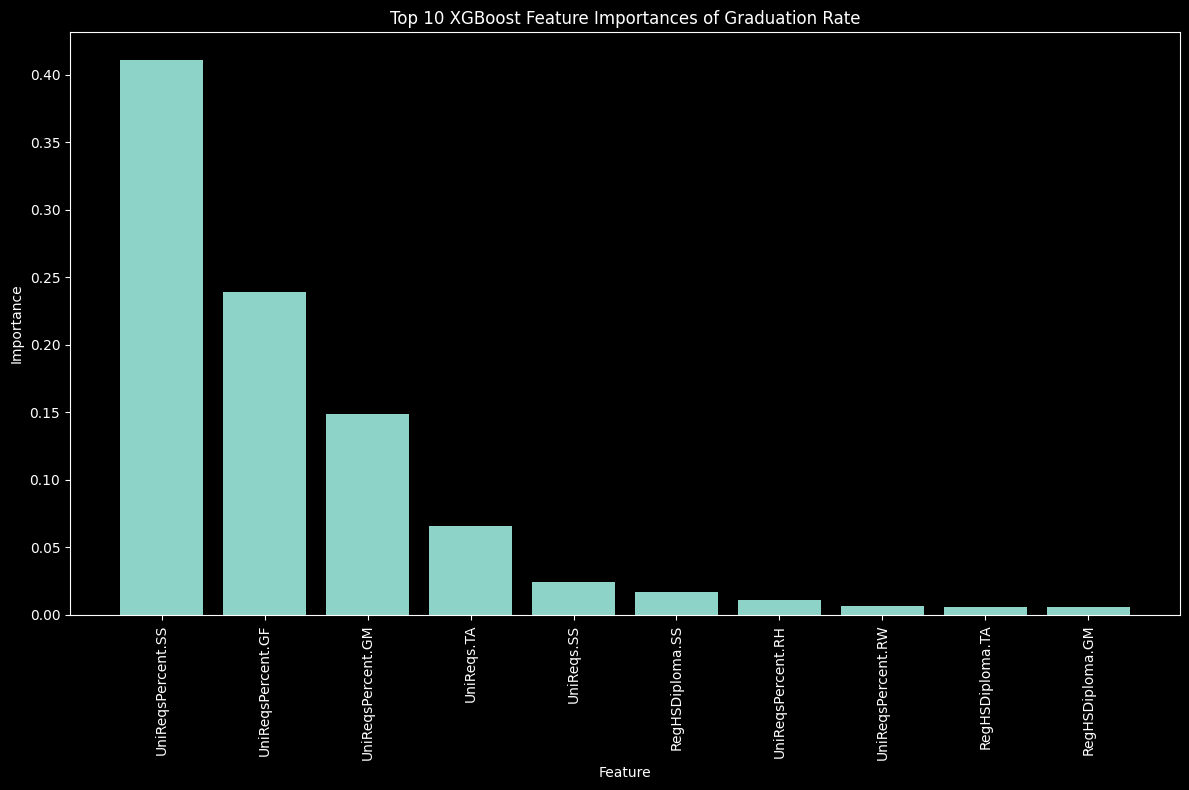

In [24]:
target_col = 'RegHSDiplomaRate.TA'

# Reset df
df = get_data_xgb()

# Remove rows where y is NaN or infinite or too large
mask = y.notna() & np.isfinite(y) & (np.abs(y) < 1e10)
X = X[mask]
y = y[mask]

xgb_regressor_uni = xgb.XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6,  
    subsample=0.8,  
    colsample_bytree=0.8, 
    missing=np.nan, 
    random_state=42
)

xgb_regressor_uni.fit(X, y)

# Get feature importances
importances_uni = xgb_regressor_uni.feature_importances_
feature_names_uni = X.columns
indices_uni = np.argsort(importances_uni)[::-1]

print("Feature ranking:")
for f in range(len(feature_names_uni)):
    print(f"{f + 1}. {feature_names_uni[indices_uni[f]]} ({importances_uni[indices_uni[f]]})")

# Plot top 10 feature importances for Graduation Rate
top_n = 10
top_indices = indices_uni[:top_n]
plt.figure(figsize=(12, 8))
plt.bar(range(top_n), importances_uni[top_indices], align='center')
plt.xticks(range(top_n), feature_names_uni[top_indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Top 10 XGBoost Feature Importances of Graduation Rate")
plt.tight_layout()
plt.show()

### Model Validation

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the XGBoost model
xgb_regressor_uni.fit(X_train, y_train)

# Make predictions
y_pred = xgb_regressor_uni.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"R^2 Score: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

R^2 Score: 0.9993864067216641
Mean Squared Error: 0.6062214842077986
Root Mean Squared Error: 0.7786022631663735
Mean Absolute Error: 0.3633171947243512


### Residuals

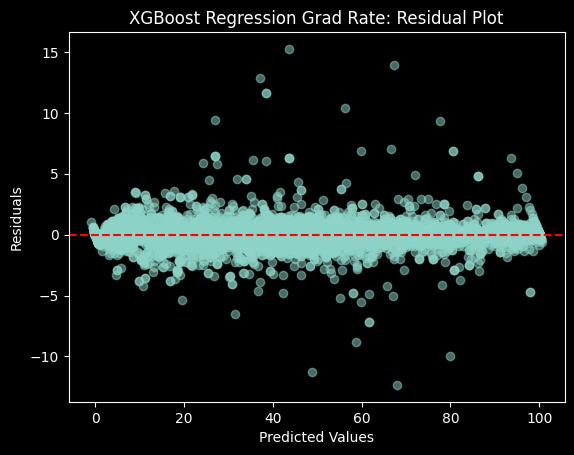

In [26]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("XGBoost Regression Grad Rate: Residual Plot")
plt.show()

### Actual vs. Predicted

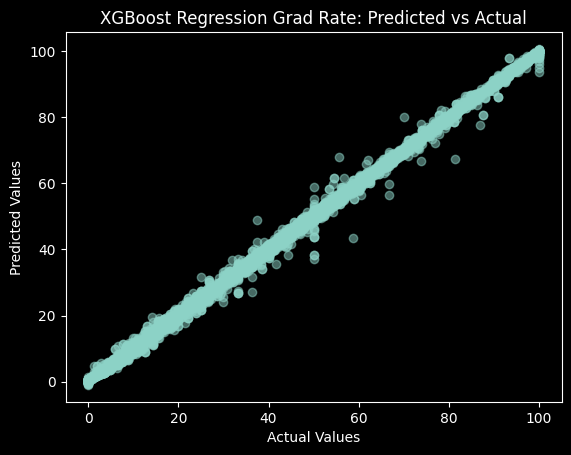

In [27]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost Regression Grad Rate: Predicted vs Actual")
plt.show()

In [28]:
con.close()